In [252]:
from openparticle import ParticleOperator, Fock
from openparticle.utils import get_fock_basis, generate_matrix

import numpy as np
from scipy.linalg import expm
from symmer import PauliwordOp
from functools import reduce
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)

In [277]:
#Parameters
Lambda = 2**4 - 1

t = 0.1

Ef, Eb, g = 1, 1, 1

In [278]:
def get_bare_hamiltonian(Ef, Eb, g):
    return Ef * ParticleOperator('b0^ b0') + Eb * ParticleOperator('a0^ a0') +\
        g * ParticleOperator('b0^ b0') * (ParticleOperator('a0^') + ParticleOperator('a0')) 

In [279]:
def phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    return expm(-1j * Ef * t * a_dagger_a_matrix)

def padded_phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta I.. \otimes a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    padded_a_dagger_a_matrix = np.kron(np.eye(2), a_dagger_a_matrix)
    return expm(-1j * Ef * t * padded_a_dagger_a_matrix)

def fermion_Rz_gate(Eb, t):
    # exp(-1j theta b^dagger b)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    return expm(-1j * Eb * t / 2 * (I - Z))

def padded_fermion_Rz_gate(Eb, t, Lambda):
    # exp(-1j theta b^dagger b \otimes I...)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b = (I - Z) / 2
    b_dagger_b_padded = reduce(np.kron, [b_dagger_b, np.eye(Lambda + 1)])

    return expm(-1j * Eb * t * b_dagger_b_padded)

def naive_interaction_gate(g, t, Lambda):
    a_dagger_plus_a_matrix = generate_matrix(ParticleOperator('a0^') + ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0^') + ParticleOperator('a0'), Lambda))
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b_matrix = (I - Z)/2

    interaction_term = np.kron(b_dagger_b_matrix, a_dagger_plus_a_matrix)
    return expm(-1j * g * t * interaction_term)

def displacement_operator(alpha, Lambda):
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))

    return expm(
        alpha * adagger - alpha.conjugate() * a
    )

def sdf_displacement_operator(alpha, Lambda):
    #spin-dependent force (SDF)
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))
    X = PauliwordOp.from_dictionary({'X': 1.0}).to_sparse_matrix.toarray()
    return expm(
        np.kron(X, alpha * adagger - alpha.conjugate() * a)
    )

def native_interaction_gate(g, t, Lambda):
    alpha = -1j * g * t / 2
    Had = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
    padded_had = reduce(np.kron, [Had, np.eye(Lambda + 1)])
    padded_identity = np.array([[1, 0], [0, 1]])
    return np.kron(padded_identity, displacement_operator(alpha, Lambda)) @ (padded_had @ sdf_displacement_operator(-1 * alpha, Lambda) @ padded_had)

def trotterized_unitary(Ef, Eb, g, t, Lambda):
    R_theta_boson_gate = padded_phase_space_rotation_gate(Ef, t, Lambda)
    R_theta_fermion_gate = padded_fermion_Rz_gate(Eb, t, Lambda)
    R_theta_interaction_gate = naive_interaction_gate(g, t, Lambda)
    # R_theta_interaction_gate = native_interaction_gate(g, t, Lambda)

    return R_theta_boson_gate @ R_theta_fermion_gate @ R_theta_interaction_gate

In [280]:
U = trotterized_unitary(Ef, Eb, g, t, Lambda)

single_fermion_state = Fock([0], [], []).to_qubit_state(max_fermionic_mode=0).to_sparse_matrix.toarray()
no_boson_state = np.zeros((Lambda + 1, 1)).reshape(-1, 1)
no_boson_state[0] = 1
statevector = np.kron(single_fermion_state, no_boson_state)

In [281]:
single_fermion_state

array([[0.+0.j],
       [1.+0.j]])

In [282]:
statevector

array([[0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [283]:
trotterized_unitary(Ef, Eb, g, 0, Lambda)

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]])

In [284]:
def evolve_statevector(t, Ef, Eb, g, Lambda, statevector):
    return trotterized_unitary(Ef, Eb, g, t, Lambda) @ statevector

In [285]:
evolve_statevector(1, Ef, Eb, g, Lambda, statevector)

array([[ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 3.27709914e-01-5.10377952e-01j],
       [-5.51516768e-01+2.52405815e-01j],
       [ 4.24589905e-01+6.05238232e-02j],
       [-1.87395729e-01-1.61852034e-01j],
       [ 3.51195209e-02+1.18722067e-01j],
       [ 1.54707949e-02-5.31631124e-02j],
       [-1.70412541e-02+1.48505665e-02j],
       [ 8.45261463e-03-1.24308431

In [286]:
number_operator_ferm = ParticleOperator('b0^ b0')
number_operator_ferm_matrix = generate_matrix(number_operator_ferm, get_fock_basis(number_operator_ferm, Lambda))
padded_number_operator_ferm_matrix = reduce(np.kron, [number_operator_ferm_matrix, np.eye(Lambda + 1)])

number_operator_bose = ParticleOperator('a0^ a0')
number_operator_bose_matrix = generate_matrix(number_operator_bose, get_fock_basis(number_operator_bose, Lambda))
padded_number_operator_bose_matrix = reduce(np.kron, [np.eye(2), number_operator_bose_matrix])

In [287]:
evolve_statevector(0, Ef, Eb, g, Lambda, statevector)

array([[0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [288]:
num_fermion_list = []
num_boson_list = []

t_arr = np.linspace(0,100,1000)

for t in t_arr:

    evolved_statevector = evolve_statevector(t, Ef, Eb, g, Lambda, statevector)
    num_fermion = evolved_statevector.T.conjugate() @ padded_number_operator_ferm_matrix @ evolved_statevector
    num_boson = evolved_statevector.T.conjugate() @ padded_number_operator_bose_matrix @ evolved_statevector
    num_fermion_list.append(num_fermion[0].real)
    num_boson_list.append(num_boson[0].real)


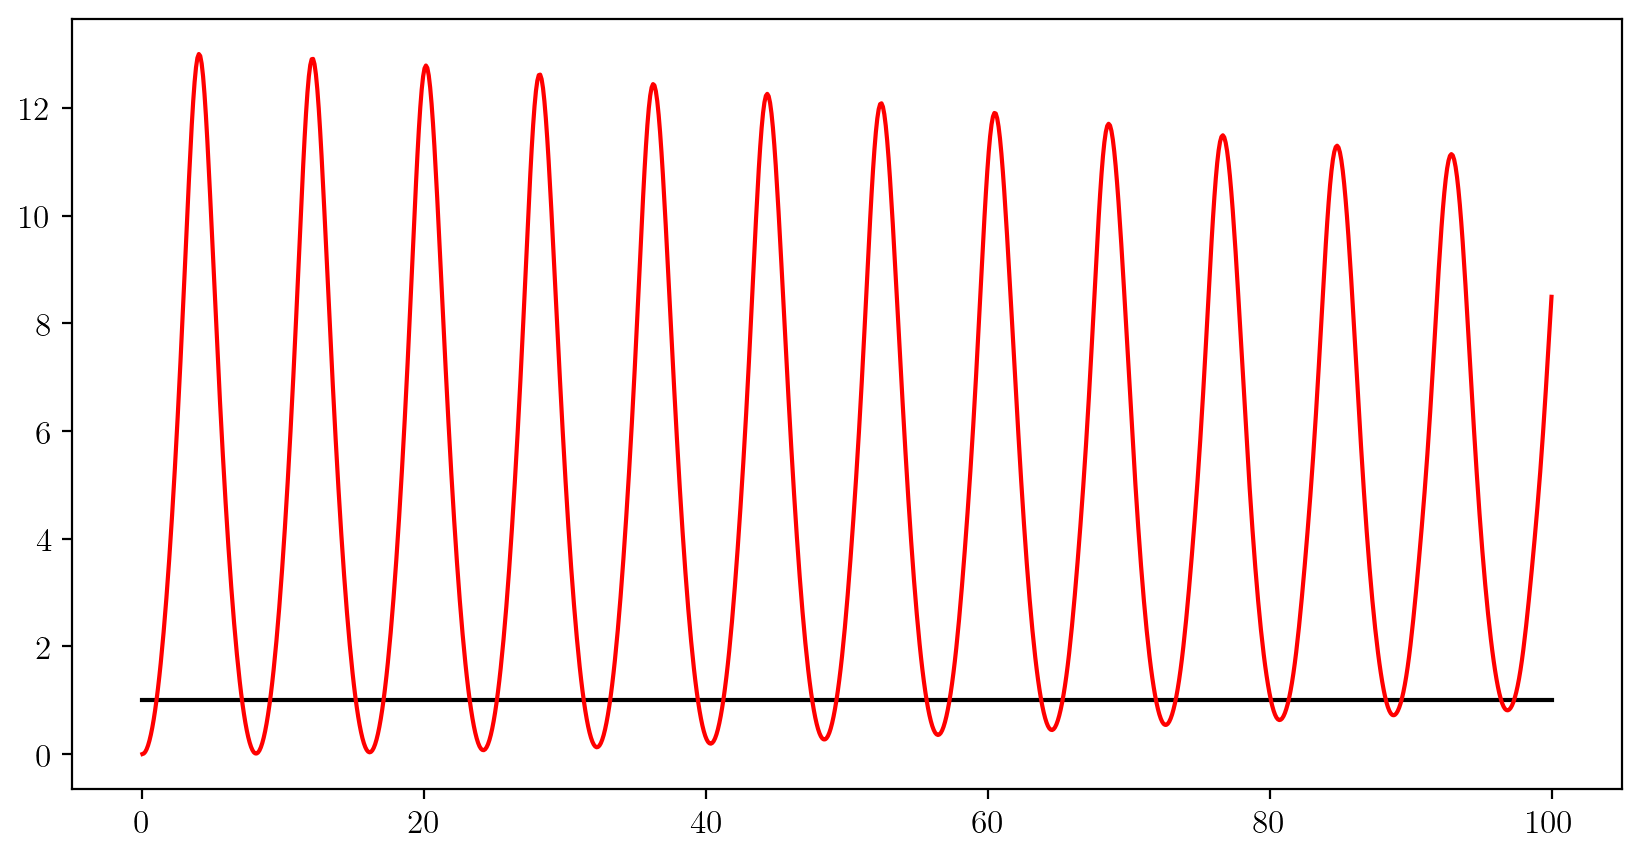

In [289]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(t_arr, np.array(num_fermion_list), color = 'k')
plt.plot(t_arr, np.array(num_boson_list), color = 'r')

In [ ]:
np.allclose(
    native_interaction_gate(1, 1, 3),
    naive_interaction_gate(1, 1, 3)
)

True

In [ ]:
np.eye(2**(Lambda - 1)).shape

(4, 4)

In [ ]:
reduce(np.kron, [Had, np.eye(2**(Lambda - 1))]).shape

(8, 8)

In [ ]:
R_theta_gate = phase_space_rotation_gate(Ef, t, Lambda)